In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
august_prior_year_calc_temps = calc_temps('2017-08-01','2017-08-07')
print(august_prior_year_calc_temps)

[(72.0, 79.25, 83.0)]


([], [])

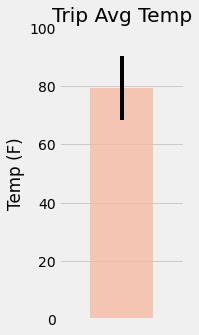

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tavg = pd.DataFrame([august_prior_year_calc_temps[0][1]])
tmin = august_prior_year_calc_temps[0][0]
tmax = august_prior_year_calc_temps[0][2]

peak_to_peak = tmax - tmin

fig = tavg.plot(kind='bar',yerr=peak_to_peak, alpha=0.75, color='#F7B79F',legend=False,figsize=(2,5))
fig.set_ylim(0,100)
fig.set_title('Trip Avg Temp')
fig.set_ylabel('Temp (F)')

# Remove xtick - approach taken from https://stackoverflow.com/questions/37039685/hide-axis-values-but-keep-axis-tick-labels-in-matplotlib
plt.xticks([])

### Daily Rainfall Average

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'

total_rainfall_by_station = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
                                          group_by(Measurement.station).\
                                          filter(Measurement.station == Station.station).\
                                          filter(Measurement.date >= start_date).\
                                          filter(Measurement.date <= end_date).\
                                          order_by(func.sum(Measurement.prcp).desc()).\
                                          statement

total_rainfall_by_station_df = pd.read_sql_query(total_rainfall_by_station,session.bind)
total_rainfall_by_station_df = total_rainfall_by_station_df.rename(columns={"sum_1": "Total Rainfall"})
total_rainfall_by_station_df   


,station,name,latitude,longitude,elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [30]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [59]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017,8,1)
end_date = dt.date(2017,8,7)
delta = dt.timedelta(days=1)
date_range = []

# Use the start and end date to create a range of dates
while start_date <= end_date:
    date_range.append(start_date)
    start_date += delta

# Strip off the year and save a list of strings in the format %m-%d

normals = []
for date in date_range:
    formatted_date = date.strftime('%m-%d')    
    # Use the `daily_normals` function to calculate the normals for each date string 
    # and append the results to a list called `normals`.
    
    normal = daily_normals(formatted_date)
    normals_dict = {}
    normals_dict['date'] = formatted_date
    normals_dict['tmin'] = normal[0][0]
    normals_dict['tmax'] = normal[0][2]
    normals_dict['tavg'] = normal[0][1]
    
    normals.append(normals_dict)
    
print(normals)

[{'date': '08-01', 'tmin': 67.0, 'tmax': 83.0, 'tavg': 75.54}, {'date': '08-02', 'tmin': 68.0, 'tmax': 84.0, 'tavg': 75.60377358490567}, {'date': '08-03', 'tmin': 70.0, 'tmax': 85.0, 'tavg': 76.61111111111111}, {'date': '08-04', 'tmin': 69.0, 'tmax': 84.0, 'tavg': 76.71153846153847}, {'date': '08-05', 'tmin': 69.0, 'tmax': 82.0, 'tavg': 76.14814814814815}, {'date': '08-06', 'tmin': 67.0, 'tmax': 83.0, 'tavg': 76.25}, {'date': '08-07', 'tmin': 71.0, 'tmax': 83.0, 'tavg': 77.15686274509804}]


In [65]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals)
trip_dates = trip_dates.set_index('date')
trip_dates

,tmin,tmax,tavg
date,,,
08-01,67.0,83.0,75.540000
08-02,68.0,84.0,75.603774
08-03,70.0,85.0,76.611111
08-04,69.0,84.0,76.711538
08-05,69.0,82.0,76.148148
08-06,67.0,83.0,76.250000
08-07,71.0,83.0,77.156863


<AxesSubplot:xlabel='Date', ylabel='Temperature'>

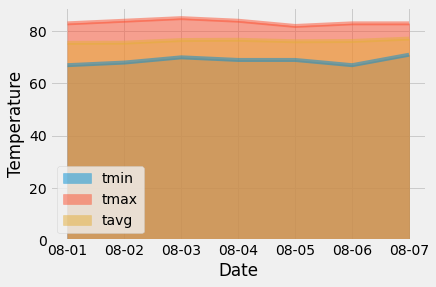

In [70]:
# Plot the daily normals as an area plot with `stacked=False`
area_chart = trip_dates.plot(kind='area',stacked=False)
area_chart.set_ylabel('Temperature')
area_chart.set_xlabel('Date')
area_chart

## Close Session

In [68]:
session.close()